In [ ]:
import numpy as np
import pyparsing as pp
import copy
import gym
import math
import random
from collections import namedtuple, deque
# from estimator import cost_estimate
# from env import env
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import plot
import yaml

# estimator

In [ ]:
PRINT_TOGGLE=False
# scale=2320515 #without cache
# scale=1
scale =412622 # with cache
test_cost=[]
table_column_name = pp.Word(pp.alphas+pp.nums+'_* "')

single_hash_cond = table_column_name + '.' + table_column_name \
  + '=' + table_column_name + '.' + table_column_name
single_hash_cond = single_hash_cond('cond*')

multi_cond = '(' + single_hash_cond +')' + pp.OneOrMore(pp.Literal('AND') + \
  pp.Literal('(') + single_hash_cond + ')')
hash_cond_parser = '(' + pp.Or([single_hash_cond, multi_cond]) + ')'

def simple_repr(plan):
  node_type = plan['Node Type']
  mapping = dict([
    ('Hash Join', 'Hash Cond'),
    ('Merge Join', 'Merge Cond'),
    ('Nested Loop', 'Join Filter')
  ])
  return '[{}]/[{}]({}..{}): {}'.format(node_type, plan.get('Join Type'), \
    plan.get('Startup Cost'), plan.get('Total Cost'), plan.get(mapping.get(node_type)))
class estimator():
  def __init__(self,db,greedy=False) -> None:
    if greedy:
      self.env_cache=db
    else:
      self.env_cache=copy.deepcopy(db)
      # self.env_cache=db
      # self.greedy=greedy
  def _estimate_network_cost(self,plan, num_nodes, alias_dict):
    if 'Plans' in plan:
      children_costs = list()
      for subnode in plan['Plans']:
        cost=self._estimate_network_cost(subnode, num_nodes, alias_dict)
        children_costs.append(cost)

      # children_costs.append(_estimate_network_cost(subnode, env, num_nodes, alias_dict))
      current_cost = self.estimate_network_cost_for_single_plan_node(plan, num_nodes, alias_dict) 
      # current_cost = estimate_network_cost_for_single_plan_node(plan, env, num_nodes, alias_dict) 
      return (sum(children_costs) + current_cost)
    else:
      # cost = # rows * width
      return 0

  def estimate_network_cost_for_single_plan_node(self,plan,num_nodes, alias_dict):
    name = plan['Node Type']
    if 'Join' in name:
      if PRINT_TOGGLE:
        print('computing cost for ', simple_repr(plan))
      sub_costs = list()
      for subplan in plan['Plans']:
        if subplan['Parent Relationship'] not in ['Outer', 'Inner']:
          continue
        sub_cost = subplan['Plan Rows'] * subplan['Plan Width']
        sub_costs.append(sub_cost)
      # let's estimate
      # parse details.
      # find hash cond 
      cost = None
      if name == 'Hash Join': # hash left/right/semi join
        cost = self.estimate_hash_join_cost(plan, sub_costs,num_nodes, alias_dict)
      elif name.startswith('Merge'): # merge left/right/full join
        print('Merge')
      #   cost = estimate_merge_join_cost(plan, sub_costs, partition_scheme, num_nodes)
      elif name.startswith('Nested Loop'): # nested loop anti/left/semi join
        print('Nested Loop')
        # cost = estimate_nested_loop_join_cost(plan, sub_costs, partition_scheme, num_nodes)
      else:
        assert False, 'Join type [{}] is not handled'.format(name)
      if PRINT_TOGGLE:
        print('cost:', cost)
      return cost
    elif 'Nested Loop' in name:
      if PRINT_TOGGLE:
        print('computing cost for ', simple_repr(plan))
      # TODO: FIXME: we currently perform a repatitioned join; could be optimized.
      sub_costs = list()
      for subplan in plan['Plans']:
        cost = subplan['Plan Rows'] * subplan['Plan Width']
        sub_costs.append(cost)
      cost = sum(sub_costs)
      if PRINT_TOGGLE:
        print('cost:', cost)
      return cost
    # elif 'Append' in name:
    #   # TODO: FIXME: we may need to consider the result as a temporal table and distribute it.
    #   # append node, assume no network cost
    #   return 0
    else:
      if PRINT_TOGGLE:
        print('ignore node ', simple_repr(plan))
      sub_plans = plan['Plans']
      sub_plans = list(filter(lambda x: x['Parent Relationship'] == 'Outer', sub_plans))
      # assert only one node. ()
      assert len(sub_plans) <= 1, \
        'expecting only one child, but got {}; \n{}'.format(len(sub_plans), plan)
      return 0
  def estimate_hash_join_cost(self,plan, sub_costs, num_nodes, alias_dict=None):
    # print('parsing', cond_str, sub_costs)
    cond_str = plan['Hash Cond']
    matched_arr = hash_cond_parser.parseString(cond_str)
    conditions = matched_arr.asDict()['cond']
    # multiple conditions
    table_column_list_dict = {}
    left_table, right_table = None, None
    for cond in conditions:
      left_table, left_column = cond[0].strip(), cond[2].strip()
      right_table, right_column = cond[4].strip(), cond[6].strip()
      if left_table not in table_column_list_dict:
        table_column_list_dict[left_table]=[]
      if right_table not in table_column_list_dict:
        table_column_list_dict[right_table]=[]
      table_column_list_dict[left_table].append(left_column)
      table_column_list_dict[right_table].append(right_column)
      # print(left_table,right_table)
    # exit()
    assert len(table_column_list_dict) == 2, \
      'Too many tables! expecting 2 but got [{}:{}]'.format(len(table_column_list_dict), table_column_list_dict.keys())
    assert len(table_column_list_dict[left_table]) == len(conditions), 'assertion failed'
    assert len(table_column_list_dict[right_table]) == len(conditions), 'assertion failed'
    left_join_columns = set(table_column_list_dict[left_table])
    right_join_columns = set(table_column_list_dict[right_table])

    is_left_partitioned=True
    is_right_partitioned=True
    # TODO some attrs are partitioned keys, while others are not? In general, hash join has only two participants
    for attr in left_join_columns:
      if self.env_cache.partition_scheme[left_table][attr]==0:
        is_left_partitioned=False
        break
    for attr in right_join_columns:
      if self.env_cache.partition_scheme[right_table][attr]==0:
        is_right_partitioned=False
        break
    # print(left_join_columns,left_table)

    is_left_replicated = self.env_cache.replicated_table[left_table]
    is_right_replicated = self.env_cache.replicated_table[right_table]
    # print(left_table, left_join_columns, right_table, right_join_columns)
    # print('left, right', is_left_partitioned, is_right_partitioned)
    left_cost, right_cost = sub_costs
    # print(left_cost,right_cost)

    ## SEPARATE ESTIMATION
    if (is_left_partitioned and is_right_partitioned) or \
    (is_left_replicated and is_right_partitioned) or\
        (is_left_partitioned and is_right_replicated):
      # okay!
      if PRINT_TOGGLE:
        print('co-partitioned', is_left_partitioned, is_right_partitioned)
          # is_left_replicated, is_right_replicated)
      return 0
    else:
      left_colocated_cost=0 if is_left_partitioned else left_cost
      right_colocated_cost=0 if is_right_partitioned else right_cost
      left_broadcast_join = 0 if is_left_replicated else left_cost*num_nodes
      right_broadcast_join = 0 if is_right_replicated else right_cost*num_nodes
      repartitioned_join_cost=left_colocated_cost+right_colocated_cost     
      broadcast_join = min(left_broadcast_join, right_broadcast_join)
      if PRINT_TOGGLE:
        print('repartition', repartitioned_join_cost, 'broadcast', broadcast_join)
      if broadcast_join < repartitioned_join_cost:
        # add broadcast 
        if left_cost < right_cost:
          # add left
          if not is_left_replicated and left_table!='lineorder':
            self.env_cache.replicated_table[left_table]=1
        else:
          # add right
          if not is_right_replicated and right_table!='lineorder':
            # partition_scheme.add_scheme(right_table, replicate=True)
            self.env_cache.replicated_table[right_table]=1
            # print('right broadcasted')
        if PRINT_TOGGLE:
          print('select broadcast join')
      else:
        # repartition join, add both schemes
        if not is_left_partitioned:
          # self.env_cache.partition((left_table,left_join_columns))
          for col in left_join_columns:
            self.env_cache.partition_scheme[left_table][col]=1
          # partition_scheme.add_scheme(left_table, column_set=set(left_join_columns))
        if not is_right_partitioned:
          for col in right_join_columns:
            self.env_cache.partition_scheme[right_table][col]=1
          # partition_scheme.add_scheme(right_table, column_set=set(right_join_columns))
        if PRINT_TOGGLE:
          print('select repartition join')

      return min(repartitioned_join_cost, broadcast_join)
import json,os
def cost_estimate(env,greedy):
  costs=[]
  root='demo/'
  e=estimator(env,greedy)
  files=['q1-1.json','q1-2.json','q1-3.json',\
         'q2-1.json','q2-2.json','q2-3.json',\
         'q3-1.json','q3-2.json','q3-3.json',\
         'q4-1.json','q4-2.json','q4-3.json']
  for file in files:
    with open(os.path.join(root,file)) as fp:
      plan=json.load(fp)
      # costs.append(e._estimate_network_cost(plan[0][0][0]['Plan'],2,0))
      cost=e._estimate_network_cost(plan[0][0][0]['Plan'],2,0)
      costs.append(cost)
      # print(file)
      # print(cost)
      # print(_estimate_network_cost(plan[0][0][0]['Plan'],db.partition_scheme,0,0)) 
      fp.close()
  return -np.array([sum(costs)])/scale


In [ ]:
# from env import env
# if __name__ == "__main__":
db=env()
# db.replicated_table['part']=1
db.partition_scheme['lineorder']['lo_suppkey']=1
# db.partition_scheme['supplier']['s_suppkey']=1
#   db.partition_scheme['part']['p_partkey']=1
#   db.partition_scheme['customer']['c_custkey']=1
#   db.partition_scheme['dim_date']['d_year']=1 

print(cost_estimate(db,False))

[-0.99633563]


# env

In [ ]:
error=False
# from estimator import *
# import json,os
class env():
    def __init__(self) -> None:
        with open("db_config.yaml", "r") as stream:
            try:
                dumped=yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print(exc)
        self.partition_scheme={}
        self.replicated_table={}
        self.db_config={}
        n_attr=0
        for table,attributes in dumped['tables'].items():
            # db_config[table]={"action":1}
            self.replicated_table[table]=0
            self.partition_scheme[table]={}
            for attr in attributes:
                self.partition_scheme[table][attr]=0   
            self.db_config[table]=[(n_attr,n_attr+len(attributes)),attributes]
            n_attr+=len(attributes)
        with open('foreign_key.txt','r') as fw:
            key_pairs=fw.readlines()

        self.fk_edges={} #((tbl_1,attr_1),(tbl_2,attr_2))=is_activated
        for pair in key_pairs:
            pair=pair.strip('\n').replace(' ','').split('=')
            edge=[]
            for each in pair:
                for table,attributes in dumped['tables'].items():
                    if each in attributes:
                        edge.append((table,each))
            self.fk_edges[(edge[0],edge[1])]=0   

        self.fk_info={} #tbl_1=[((tbl_1,attr_1),(tbl_2,attr_2))]
        self.get_fk_info()
        # self.action_type=['partition','replicate','activate',"deactivate"]
    def get_fk_info(self):
        for pair in self.fk_edges:
            if pair[0][0] not in self.fk_info:
                self.fk_info[pair[0][0]]=[]
            if pair[1][0] not in self.fk_info:
                self.fk_info[pair[1][0]]=[]            
            self.fk_info[pair[0][0]].append(pair)
            self.fk_info[pair[1][0]].append(pair)
    def replicate(self,table):
      if self.replicated_table[table]==0:
        self.replicated_table[table]=1
        for attr in self.partition_scheme[table]:
            self.partition_scheme[table][attr]=0
        for edge in self.fk_info[table]:
            self.deactivate(edge)   
      # else:
      #   self.replicated_table[table]=0 #TODO Better undo?
      # print(self.replicated_table)
    def reset(self):
        for tbl in self.partition_scheme:
            tbl_attr=self.partition_scheme[tbl]
            for attr in tbl_attr:
                tbl_attr[attr]=0
            self.partition_scheme[tbl]=tbl_attr
        for edge in self.fk_edges:
            self.fk_edges[edge]=0
        for tbl in self.replicated_table:
            self.replicated_table[tbl]=0
    def partition(self,pair):
        table,attr=pair
        if self.partition_scheme[table][attr]==0:
          for edge in self.fk_info[table]:
              if pair not in edge and self.fk_edges[edge]==1:
                  self.deactivate(edge)
          for each in self.db_config[table][1]: #Only one attr can be partitioned key
              self.partition_scheme[table][each]=0                    
          self.partition_scheme[table][attr]=1
          self.replicated_table[table]=0
        # else:
        #   self.replicate(table)

        # display(self.partition_scheme)
    def step(self,action_idx):
        n_fk_edges=4
        n_tables_attr=58
        # old_state=self.get_current_state()
        if action_idx<n_fk_edges:
            candidates=list(self.fk_edges.keys())
            edge=candidates[action_idx]
            if self.fk_edges[edge]==0:
                tbl_1,tbl_1_attr,tbl_2,tbl_2_attr=edge[0][0],edge[0][1],edge[1][0],edge[1][1] # to be activated
                for e in self.fk_info[tbl_1]:
                    if (tbl_1,tbl_1_attr) not in e and self.fk_edges[e]==1:
                        self.deactivate(e)
                        break
                for e in self.fk_info[tbl_2]:
                    if (tbl_2,tbl_2_attr) not in e and self.fk_edges[e]==1:
                        self.deactivate(e)
                        break            
                self.fk_edges[edge]=1
                self.partition_scheme[tbl_1][tbl_1_attr]=1
                self.partition_scheme[tbl_2][tbl_2_attr]=1
                self.replicated_table[tbl_1]=0
                self.replicated_table[tbl_2]=0
                msg='activate {}'.format(edge)
            else:
                # self.fk_edges[edge]=0
                # tbl_1,tbl_1_attr,tbl_2,tbl_2_attr=edge[0][0],edge[0][1],edge[1][0],edge[1][1] # to be Deactivated
                # self.partition_scheme[tbl_1][tbl_1_attr]=0
                # self.partition_scheme[tbl_2][tbl_2_attr]=0  
                self.deactivate(edge)   
                msg='deactivate {}'.format(edge)
        elif action_idx<n_fk_edges+n_tables_attr:
            action_idx-=n_fk_edges
            for table,attr_info in self.db_config.items():
                attr_range=attr_info[0]
                if action_idx>= attr_range[0] and action_idx<attr_range[1]:
                    break
            attr_list=attr_info[1]
            attr=attr_list[action_idx-attr_range[0]]  
            pair=(table,attr)
            self.partition(pair)
            msg='partition {}'.format(attr)
        else:
            action_idx-=n_fk_edges+n_tables_attr
            table_list=list(self.partition_scheme.keys())
            table=table_list[action_idx]
            if table=='lineoder':
              error=True
            self.replicate(table)
            for edge in self.fk_info[table]:
                self.deactivate(edge)
            msg='replicate {}'.format(table)
        return  self.get_current_state(),msg 
    def get_current_state(self):
        return np.array([list(self.fk_edges.values())+ self.get_table_states()])
    def deactivate(self,edge):
        self.fk_edges[edge]=0
        tbl_1,tbl_1_attr,tbl_2,tbl_2_attr=edge[0][0],edge[0][1],edge[1][0],edge[1][1] # to be Deactivated
        if tbl_1=='lineorder':
            self.partition_scheme[tbl_1][tbl_1_attr]=0
            self.replicate(tbl_2)
        elif tbl_2=='lineorder':
            self.partition_scheme[tbl_2][tbl_2_attr]=0
            self.replicate(tbl_1)
        else:
            self.replicate(tbl_1)
            self.replicate(tbl_2)
    def cost_estimate(self):
        # TODO partition scheme and plans
        pass
    def get_table_states(self):
        # self.table_states=[]
        table_states=[]
        for table,attributes in self.partition_scheme.items():
            table_states+=[self.replicated_table[table]]+list(attributes.values()) 
        return table_states


#Memory

In [ ]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(run_num)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))
    def push_numpy(self, args):
      # print(args[0].shape,args[1].shape)
      self.push(torch.from_numpy(args[0]),args[1],torch.from_numpy(args[2]),torch.from_numpy(args[3]))

    def sample(self, batch_size):
        # random.seed(0)
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN

In [ ]:
n_states=67
n_actions=67
import torch.nn.functional as F
# class DQN(nn.Module):
#     def __init__(self):
#         super(DQN, self).__init__()
#         # self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             # nn.Linear(np.array(env.observation_space.shape).prod(), 128, bias=False),
#             nn.Linear(n_states, 128, bias=False),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, n_actions),
#         )
#         self.head = nn.Linear(n_states, n_actions)

#     def forward(self, x):
#         x = x.float()
#         x = self.linear_relu_stack(x)
#         print('forward output',x.shape)
#         print('reshaped',x.view(x.size(0), -1).shape)
#         if x.size(0)==n_actions:
#           return self.head(x.view(1,-1))
#         else:
#           return self.head(x.view(x.size(0), -1))

class DQN(nn.Module):

  def __init__(self):
    super(DQN, self).__init__()
    self.hidden1 = nn.Linear(n_states, 128)
    self.hidden2 = nn.Linear(128, 64)
    self.output = nn.Linear(64, n_actions)
    # self.head = nn.Linear(n_states, n_actions)

  def forward(self, x):
    x = x.to(device)
    x = x.float()
    # print(x.shape)
    x = F.relu(self.hidden1(x))
    x = F.relu(self.hidden2(x))
    x = self.output(x)
    # print('forward output',x.shape)
    # print('reshaped',x.view(x.size(0), -1).shape)
    # return self.head(x.view(x.size(0), -1))
    return x


def display(scheme):
    ret_dict={}
    for table,values in scheme.items():
        for attr,val in values.items():
            if val==1:
                ret_dict[table]=attr
                break
    print(ret_dict)

In [ ]:
68%67

1

# Agent

In [ ]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
# EPS_DECAY = 0.997
EPS_DECAY = 0.005
TARGET_UPDATE = 10
learning_rate=5e-4
mask_fact_table=[True]*67
mask_fact_table[64]=False # not replicate lineorder
action_mask=torch.from_numpy(np.array(mask_fact_table)).to(device=device) 
class agent():
    def __init__(self) -> None:
        self.policy_net=DQN().float().to(device)
        self.target_net=DQN().float().to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(),learning_rate)
        self.memory = ReplayMemory(10000)
        self.steps_done=0
    def select_action(self,state):
        # random.seed(0)
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * self.steps_done * EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
              output=self.policy_net(torch.FloatTensor(state).unsqueeze(0)) # mask fact table replication
              max_idx=torch.masked_select(output.squeeze(0), action_mask).max(0)[1]
              kept_idx=action_mask.nonzero()
              action= kept_idx[max_idx].view(1,1) 
              return action,'max'               
              # return self.policy_net(torch.FloatTensor(state)).max(1)[1].view(1, 1),'max'
        else:
            # return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long),'random' #random
            return torch.tensor([[self.steps_done%67]], device=device, dtype=torch.long),'random' #round-robin

    def optimize(self):
      BATCH_SIZE=1
      if len(self.memory) < BATCH_SIZE:
        return None      
      # print('optimized!')
      transitions = self.memory.sample(BATCH_SIZE)
      # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
      # detailed explanation). This converts batch-array of Transitions
      # to Transition of batch-arrays.
      transition_batch = Transition(*zip(*transitions))
      # state_batch = torch.stack(transition_batch.state).to(device=device)
      # action_batch = torch.stack(transition_batch.action).to(device=device)
      # reward_batch = torch.stack(transition_batch.reward).to(device=device)
      state_batch = torch.cat(transition_batch.state)
      action_batch = torch.cat(transition_batch.action)
      reward_batch = torch.cat(transition_batch.reward)  

      # print('state_batch',state_batch.shape) 
      # print('action_batch',action_batch.shape)
      # print('reward_batch',reward_batch.shape)   

      # compute Q(s_t, a)
      output=self.policy_net(state_batch)
      # print("output_shape",output.shape)
      state_action_values=output.gather(1, action_batch)
      # state_action_values = self.policy_net(state_batch).gather(1, action_batch)
      next_state_values=self.target_net(state_batch).max(1)[0].detach()
      # next_state_values= self.target_net(state_batch).max(1)[0].detach().view(state_batch.shape[0], 1)
      # print('target_output',next_state_values.shape)

      expected_state_action_values = ((next_state_values * GAMMA) + reward_batch).view(BATCH_SIZE, 1)
      # print('state_action_values',state_action_values.shape)
      # print('expected_state_action_values', expected_state_action_values.shape)
      criterion = nn.SmoothL1Loss()
      loss = criterion(state_action_values, expected_state_action_values.float())
      # Optimize the model
      self.optimizer.zero_grad()
      loss.backward()
      for param in self.policy_net.parameters():
          param.grad.data.clamp_(-1, 1)
      self.optimizer.step()
      return loss

    def train(self,db_env,num_episodes,t_max,Batch_Print,early_stopping=False,greedy=False):
        loss_plot=[]
        prev_loss=0
        loss_rise_cnt=0
        logger_cache=[]
        ps_cache=[]
        repl_cache=[]       
        reward_cache=[]
        action_cache=[]
        types_cache=[]
        for i_episode in range(num_episodes):
            # Initialize the environment and state
            db_env.reset()
            current_state =db_env.get_current_state()
            logger=[]
            # loss_cnt_EPI=0
            # prev_loss_EPI=0
            ps=[]
            repl=[]
            actions=[]
            rwrds=[]
            types=[]
            for t in range(t_max):
                # print('step', t)
                # Select and perform an action
                # TODO reduce actions when generating or stepping
                action,type_action = self.select_action(current_state)
                # action = self.select_action(current_state)
                next_state,msg = db_env.step(action.item())
                reward=cost_estimate(db_env,greedy)
                # reward_cache.append(reward)

                # Store the transition in memory
                self.memory.push_numpy((current_state, action, next_state, reward))

                # # Move to the next state
                current_state = next_state

                # Perform one step of the optimization (on the policy network)
                loss=self.optimize()
                # print(db_env.replicated_table)

                # ps.append(copy.deepcopy(db_env.partition_scheme))
                # repl.append(copy.deepcopy(db_env.replicated_table)) 
                # actions.append([action,type_action,msg])   
                # rwrds.append(reward)
                # types.append(type_action)
                if loss is not None:
                    logger.append(loss)
                    # ps.append(copy.deepcopy(db_env.partition_scheme))
                    # repl.append(copy.deepcopy(db_env.replicated_table)) 
                    # actions.append([action,type_action,msg])   
                    # rwrds.append(reward)
                    # types.append(type_action)
                if error:
                  print(action.item())
                  break
            # # Update the target network, copying all weights and biases in DQN

            # ps_cache.append(ps)
            # repl_cache.append(repl)
            # action_cache.append(actions)
            # reward_cache.append(rwrds)
            # types_cache.append(types)

            if len(logger)>1:
              if num_episodes>1:
                avg_loss=sum(logger)/len(logger)
                loss_plot.append(avg_loss)
              else:
                loss_plot=logger
                # print(len(logger))
            if (i_episode+1) % Batch_Print == 0:
                print('episode batch {} completed'.format(i_episode//Batch_Print))
                self.target_net.load_state_dict(self.policy_net.state_dict())
            if error:
              print(action.item())
              break        
            logger_cache.append(logger)   

        print('Complete')  
        # return loss_plot,reward_cache
        return loss_plot,logger_cache,ps_cache,repl_cache,action_cache,reward_cache,types_cache
        

# Train

In [ ]:
enginee=agent()
db_env=env()
setup_seed(123)
train_loss=[]

episode batch 0 completed
episode batch 1 completed
episode batch 2 completed
episode batch 3 completed
episode batch 4 completed
episode batch 5 completed
episode batch 6 completed
episode batch 7 completed
episode batch 8 completed
episode batch 9 completed
Complete


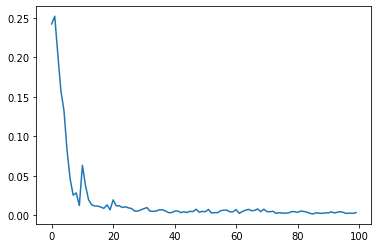

In [ ]:
stage_loss,step_loss,ps_cache,repl_cache,action_cache,reward_cache,types_cache=enginee.train(db_env,100,80,10,greedy=False)
train_loss+=stage_loss
plot([i for i in range(len(train_loss))],train_loss)

## Fine tuning

episode batch 0 completed
episode batch 1 completed
episode batch 2 completed
episode batch 3 completed
episode batch 4 completed
Complete


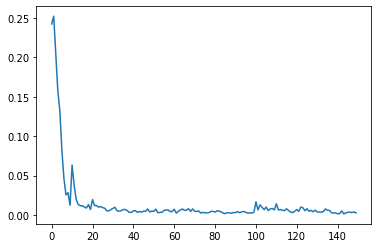

In [ ]:
stage_loss,step_loss,ps_cache,repl_cache,action_cache,reward_cache,types_cache=enginee.train(db_env,50,80,10,greedy=False)
train_loss+=stage_loss
plot([i for i in range(len(train_loss))],train_loss)

In [ ]:
enginee=agent()
db_env=env()
setup_seed(123)
train_loss=[]

episode batch 0 completed
episode batch 1 completed
episode batch 2 completed
episode batch 3 completed
episode batch 4 completed
episode batch 5 completed
episode batch 6 completed
episode batch 7 completed
episode batch 8 completed
episode batch 9 completed
Complete


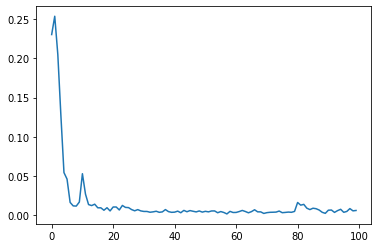

In [ ]:
stage_loss,step_loss,ps_cache,repl_cache,action_cache,reward_cache,types_cache=enginee.train(db_env,100,100,10,greedy=False)
train_loss+=stage_loss
plot([i for i in range(len(train_loss))],train_loss)

In [ ]:
enginee=agent()
db_env=env()
setup_seed(123)
train_loss=[]

episode batch 0 completed
episode batch 1 completed
episode batch 2 completed
episode batch 3 completed
episode batch 4 completed
episode batch 5 completed
episode batch 6 completed
Complete


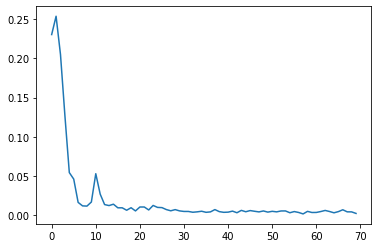

In [ ]:
stage_loss,step_loss,ps_cache,repl_cache,action_cache,reward_cache,types_cache=enginee.train(db_env,70,100,10,greedy=False)
train_loss+=stage_loss
plot([i for i in range(len(train_loss))],train_loss)

## Check training process

A simple example

In [ ]:
for idx,step in enumerate(ps_cache):
  if len(step)>0:
    print(idx)
    # for i in step:
    #   display(i)
      # action_cache[idx]

In [ ]:
for idx,value in enumerate(types_cache):
  print(idx, value.count('random'))

0 9


In [ ]:
for idx,ps in enumerate(ps_cache[19]):
  print(reward_cache[19][idx])
  print(action_cache[19][idx])
  display(ps)
  print(repl_cache[19][idx])

[-1.]
[tensor([[47]]), 'random', 'partition p_name']
{'part': 'p_name'}
{'customer': 0, 'dim_date': 0, 'lineorder': 0, 'part': 0, 'supplier': 0}
[-1.]
[tensor([[11]]), 'max', 'partition c_mktsegment']
{'customer': 'c_mktsegment', 'part': 'p_name'}
{'customer': 0, 'dim_date': 0, 'lineorder': 0, 'part': 0, 'supplier': 0}
[-1.]
[tensor([[11]]), 'max', 'partition c_mktsegment']
{'customer': 'c_mktsegment', 'part': 'p_name'}
{'customer': 0, 'dim_date': 0, 'lineorder': 0, 'part': 0, 'supplier': 0}
[-1.]
[tensor([[11]]), 'max', 'partition c_mktsegment']
{'customer': 'c_mktsegment', 'part': 'p_name'}
{'customer': 0, 'dim_date': 0, 'lineorder': 0, 'part': 0, 'supplier': 0}
[-1.]
[tensor([[11]]), 'max', 'partition c_mktsegment']
{'customer': 'c_mktsegment', 'part': 'p_name'}
{'customer': 0, 'dim_date': 0, 'lineorder': 0, 'part': 0, 'supplier': 0}
[-1.]
[tensor([[11]]), 'max', 'partition c_mktsegment']
{'customer': 'c_mktsegment', 'part': 'p_name'}
{'customer': 0, 'dim_date': 0, 'lineorder': 0, '

# Inference Engine

In [ ]:
def inference(policy_net,db_env,t_max,greedy=True):
    reward_cache=[]
    ps_cache=[]
    replicate_tbl_cache=[]
    db_env.reset()
    current_state =db_env.get_current_state()
    state_set=[]
    action_cache=[]
    for iter in range(t_max):
        # print(len(current_state))
        # output=policy_net(torch.FloatTensor(current_state))
        # action= output.max(1)[1].view(1, 1)
        output=policy_net(torch.FloatTensor(current_state).unsqueeze(0)) # mask fact table replication
        max_idx=torch.masked_select(output.squeeze(0), action_mask).max(0)[1]
        kept_idx=action_mask.nonzero()
        action= kept_idx[max_idx].view(1,1)  
        
        next_state,msg = db_env.step(action.item())
        reward=cost_estimate(db_env,greedy)     
        current_state=next_state
        reward_cache.append(reward)
        ps_cache.append(db_env.partition_scheme)
        replicate_tbl_cache.append(db_env.replicated_table)
        # print(np.where(np.array(current_state)==1))
        state_set.append(current_state)
        action_cache.append(action)
    # print(len(set(state_set)))
    max_idx=np.argmax(np.array(reward_cache))
    # return ps_cache[max_idx],replicate_tbl_cache[max_idx]
    return max_idx,ps_cache,replicate_tbl_cache,reward_cache,action_cache

## inference

In [ ]:
max_idx,ps,replicate,rewards,actions=inference(enginee.policy_net,db_env,80,False)
# print(replicate)
# display(ps)

In [ ]:
print(replicate[max_idx])#100,80,10
display(ps[max_idx])

{'customer': 1, 'dim_date': 0, 'lineorder': 0, 'part': 1, 'supplier': 0}
{'lineorder': 'lo_linenumber'}


In [ ]:
max_idx,ps,replicate,rewards,actions=inference(enginee.policy_net,db_env,80,False)
# print(replicate)
# display(ps)

In [ ]:
print(replicate[max_idx])#150,80,10
display(ps[max_idx])

{'customer': 0, 'dim_date': 0, 'lineorder': 0, 'part': 1, 'supplier': 0}
{'customer': 'c_custkey', 'dim_date': 'd_datekey', 'lineorder': 'lo_custkey'}


In [ ]:
max_idx,ps,replicate,rewards,actions=inference(enginee.policy_net,db_env,80,False)
print(replicate[max_idx]) #70,100,10
display(ps[max_idx])

{'customer': 0, 'dim_date': 1, 'lineorder': 0, 'part': 1, 'supplier': 0}
{'customer': 'c_custkey', 'lineorder': 'lo_custkey', 'supplier': 's_suppkey'}


### Check sequences returned from inference

In [ ]:
rewards[:10]

[array([-0.99292331]),
 array([-0.99292331]),
 array([-0.69714654]),
 array([-0.34519245]),
 array([-0.34519245]),
 array([-0.34519245]),
 array([-0.34519245]),
 array([-0.34519245]),
 array([-0.34519245]),
 array([-0.34519245])]

In [ ]:
actions[:10]

[tensor([[0]]),
 tensor([[0]]),
 tensor([[65]]),
 tensor([[3]]),
 tensor([[55]]),
 tensor([[55]]),
 tensor([[55]]),
 tensor([[55]]),
 tensor([[55]]),
 tensor([[55]])]

In [ ]:
np.sum(np.where(rewards==np.array([-1]),1,0))

0

In [ ]:
# replicate[:10]
display(ps[0])

{'lineorder': 'lo_shipmode'}


In [ ]:
rewards[max_idx]

array([-0.35226915])

In [ ]:
rewards[max_idx]

array([-0.35226915])

In [ ]:
max_idx

1

In [ ]:
len(rewards)

100

In [ ]:
rewards[5],rewards[9]

(array([-0.81468596]), array([-0.81468596]))

In [ ]:
print(replicate[3])
display(ps[3])
print(rewards[3])

{'customer': 0, 'dim_date': 0, 'lineorder': 0, 'part': 0, 'supplier': 0}
{'customer': 'c_mktsegment'}
[-1.86628206e-21]
